In [113]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import nltk

from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [114]:
from google.colab import drive
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [115]:
df = pd.read_csv('/content/drive/MyDrive/pengembangan-ML-dicoding/alldata_1_for_kaggle.csv', header = None, encoding='latin1') #read csv file

In [116]:
df.head() #display top rows

,0,1,2
0,NaN,0,a
1,0.0,Thyroid_Cancer,Thyroid surgery in children in a single insti...
2,1.0,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
3,2.0,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
4,3.0,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...


In [117]:
df = df[[1,2]]
df.columns=['labels','text']


In [118]:
df.tail() #display bottom rows

,labels,text
7566,Colon_Cancer,we report the case of a 24yearold man who pres...
7567,Colon_Cancer,among synchronous colorectal cancers scrcs rep...
7568,Colon_Cancer,the heterogeneity of cancer cells is generally...
7569,Colon_Cancer,"""adipogenesis is the process through which mes..."
7570,Colon_Cancer,the periparturient period is one of the most c...


In [119]:
df.dtypes #display data types

labels    object
text      object
dtype: object

In [120]:
df.describe() #summary statistics

,labels,text
count,7571,7571
unique,4,997
top,Thyroid_Cancer,tetrastigma hemsleyanum diels et gilg t ...
freq,2810,10


In [121]:
df.info() #display index, columns and data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7571 entries, 0 to 7570
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   labels  7571 non-null   object
 1   text    7571 non-null   object
dtypes: object(2)
memory usage: 118.4+ KB


In [122]:
len(df)

7571

In [123]:
df['targets'] = df['labels'].astype('category').cat.codes

In [124]:
df

,labels,text,targets
0,0,a,0
1,Thyroid_Cancer,Thyroid surgery in children in a single insti...,3
2,Thyroid_Cancer,""" The adopted strategy was the same as that us...",3
3,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...,3
4,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...,3
...,...,...,...
7566,Colon_Cancer,we report the case of a 24yearold man who pres...,1
7567,Colon_Cancer,among synchronous colorectal cancers scrcs rep...,1
7568,Colon_Cancer,the heterogeneity of cancer cells is generally...,1
7569,Colon_Cancer,"""adipogenesis is the process through which mes...",1


In [125]:
'''
category = pd.get_dummies(df.labels)
df_cleaned = pd.concat([df, category], axis=1)
df_cleaned = df_cleaned.drop(columns='labels')
df_cleaned
'''


"\ncategory = pd.get_dummies(df.labels)\ndf_cleaned = pd.concat([df, category], axis=1)\ndf_cleaned = df_cleaned.drop(columns='labels')\ndf_cleaned\n"

In [126]:
#df = df.sample(4000)

In [127]:
#df

In [128]:
'''
df_removed = df_cleaned.drop(columns=['0'])
df_removed2 = df_removed.drop(df_removed.index[0])
df_removed2
'''

"\ndf_removed = df_cleaned.drop(columns=['0'])\ndf_removed2 = df_removed.drop(df_removed.index[0])\ndf_removed2\n"

In [129]:
# menghilangkan tanda baca & angka pada coloumn content
def remove_punctuations_numbers(inputs):
    return re.sub(r'[^a-zA-Z]', ' ', inputs)


df['text'] = df['text'] .apply(remove_punctuations_numbers)

In [130]:
def hapus_ulasan_special(text):
    # hapus tab, new line, ans back slice
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    # hapus non ASCII (emoticon, chinese word, .etc)
    text = text.encode('ascii', 'replace').decode('ascii')
    # hapus mention @
    text = re.sub(r"[@][\w_-]+","", text)
    # hapus link, hashtag
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    # hapus incomplete URL
    return text.replace("http://", " ").replace("https://", " ")

df['text'] = df['text'].apply(hapus_ulasan_special)

In [131]:
#hapus whitespace leading & trailing
def hapus_whitespace_LT(text):
    return text.strip()

df_removed2['text'] = df_removed2['text'].apply(hapus_whitespace_LT)

#hapus multiple whitespace into single whitespace
def hapus_whitespace_multiple(text):
    return re.sub('\s+',' ',text)

df['text'] = df['text'].apply(hapus_whitespace_multiple)

# hapus single char
def hapus_singl_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

df['text'] = df['text'].apply(hapus_singl_char)

#hapus pengulangan dalam kata
def replaceThreeOrMore (text):
    #Pattern to look for three or more repetitions of any character, including newlines(contoh goool -> gool)
    pattern = re.compile(r"(.)\1{1,}", re.DOTALL)
    return pattern.sub(r"\1\1", text)

df['text'] = df['text'].apply(replaceThreeOrMore)

In [132]:
#Case Folding
df['text'] = df['text'] .str.lower()

In [133]:
# mengecek data yang telah di prepocessing
df

,labels,text,targets
0,0,,0
1,Thyroid_Cancer,thyroid surgery in children in single institu...,3
2,Thyroid_Cancer,the adopted strategy was the same as that used...,3
3,Thyroid_Cancer,coronary arterybypass grafting thrombosis brin...,3
4,Thyroid_Cancer,solitary plasmacytoma sp of the skull is an un...,3
...,...,...,...
7566,Colon_Cancer,we report the case of yearold man who present...,1
7567,Colon_Cancer,among synchronous colorectal cancers scrcs rep...,1
7568,Colon_Cancer,the heterogeneity of cancer cells is generally...,1
7569,Colon_Cancer,adipogenesis is the process through which mese...,1


In [162]:
df2 = df.drop(df.index[0])

In [164]:
df2

,labels,text,targets
1,Thyroid_Cancer,thyroid surgery in children in single institu...,3
2,Thyroid_Cancer,the adopted strategy was the same as that used...,3
3,Thyroid_Cancer,coronary arterybypass grafting thrombosis brin...,3
4,Thyroid_Cancer,solitary plasmacytoma sp of the skull is an un...,3
5,Thyroid_Cancer,this study aimed to investigate serum matrix m...,3
...,...,...,...
7566,Colon_Cancer,we report the case of yearold man who present...,1
7567,Colon_Cancer,among synchronous colorectal cancers scrcs rep...,1
7568,Colon_Cancer,the heterogeneity of cancer cells is generally...,1
7569,Colon_Cancer,adipogenesis is the process through which mese...,1


In [174]:
#bagi dataset menjadi train dan label
x = df2['text'].values
y = df2['targets'].values

In [175]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [176]:
'''
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)#
'''

'\nfrom tensorflow.keras.utils import to_categorical\n\ny_train = to_categorical(y_train, 3)\ny_test = to_categorical(y_test, 3)#\n'

In [177]:
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(x_train)
tokenizer.fit_on_texts(x_test)

sekuens_train = tokenizer.texts_to_sequences(x_train)
sekuens_test = tokenizer.texts_to_sequences(x_test)

padded_train = pad_sequences(sekuens_train)
padded_test = pad_sequences(sekuens_test)

In [185]:
'''
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(loss='categorical_crossentropy' ,optimizer='adam',metrics=['accuracy'])
'''


#buat model arsitektur dan compile
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential([
  Embedding(input_dim = 5000, output_dim = 16),
  LSTM(64),
  Dense(128, activation = 'relu'),
  Dense(64, activation = 'relu'),
  Dense(9, activation = 'softmax')
])

model.compile(
  loss = 'sparse_categorical_crossentropy',
  optimizer = 'adam',
  metrics = ['accuracy']
)

In [186]:
#buat callbacks untuk persingkat waktu pelatihan model
class myCallback(tf.keras.callbacks.Callback) :
  def end_epoch(self, epoch, logs={}):
    if(logs.get('accuracy')>0.75):
      i = logs.get('accuracy')
      self.model.stop_training =True
callbacks = myCallback()

In [187]:
history = model.fit(
  padded_train, y_train, epochs = 30,  callbacks=[callbacks],
  validation_data = (padded_test, y_test), verbose = 2)

Epoch 1/30
190/190 - 43s - loss: 1.0789 - accuracy: 0.4415 - val_loss: 0.6607 - val_accuracy: 0.5964 - 43s/epoch - 226ms/step
Epoch 2/30
190/190 - 35s - loss: 0.4221 - accuracy: 0.7962 - val_loss: 0.2457 - val_accuracy: 0.9022 - 35s/epoch - 185ms/step
Epoch 3/30
190/190 - 33s - loss: 0.1384 - accuracy: 0.9488 - val_loss: 0.0717 - val_accuracy: 0.9736 - 33s/epoch - 174ms/step
Epoch 4/30
190/190 - 29s - loss: 0.0751 - accuracy: 0.9726 - val_loss: 0.0609 - val_accuracy: 0.9696 - 29s/epoch - 154ms/step
Epoch 5/30
190/190 - 28s - loss: 0.0449 - accuracy: 0.9787 - val_loss: 0.0497 - val_accuracy: 0.9736 - 28s/epoch - 150ms/step
Epoch 6/30
190/190 - 28s - loss: 0.0487 - accuracy: 0.9808 - val_loss: 0.0472 - val_accuracy: 0.9742 - 28s/epoch - 146ms/step
Epoch 7/30
190/190 - 27s - loss: 0.0440 - accuracy: 0.9795 - val_loss: 0.0589 - val_accuracy: 0.9756 - 27s/epoch - 144ms/step
Epoch 8/30
190/190 - 27s - loss: 0.0417 - accuracy: 0.9812 - val_loss: 0.0556 - val_accuracy: 0.9762 - 27s/epoch - 144

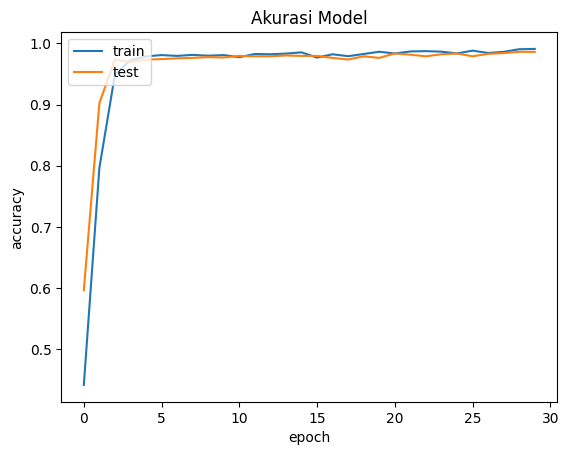

In [188]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

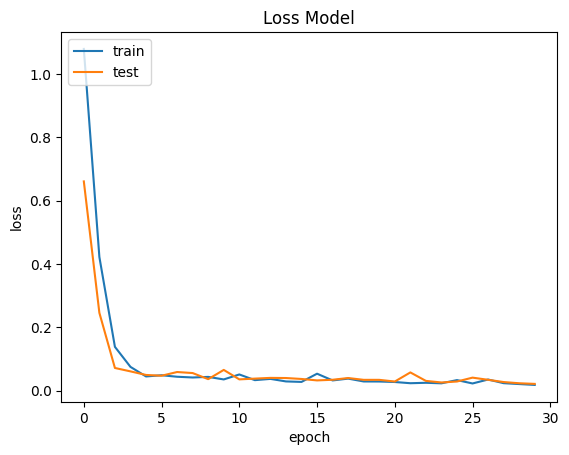

In [189]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()